<a href="https://colab.research.google.com/github/enwachukwu/abc/blob/main/Traansfer_Learning_Activty_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [ ]:
image_size = (256,256)
batch_size = 16
EPOCHS = 2
num_classes = 3

train_data_dir = '//content/drive/MyDrive/COVID-19_Radiography_Dataset/train'
test_data_dir = '//content/drive/MyDrive/COVID-19_Radiography_Dataset/test'

In [ ]:
# Create an instance of the ImageDataGenerator class with various transformations parameters.
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.2
)

In [ ]:

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 694 images belonging to 3 classes.
Found 172 images belonging to 3 classes.
Found 288 images belonging to 3 classes.


In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn
# loading B4 without the final layer, we will change it
pretrained_model = efn.EfficientNetB4(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')

x = pretrained_model.output
x = Flatten()(x)

predictions = Dense(3, activation="softmax")(x)
model = Model(inputs=pretrained_model.input, outputs=predictions )

In [ ]:
print(model.summary())

In [ ]:

def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

model.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 20,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = False,
                                                  mode = 'max')

# Group the callbacks into a list that can be passed to the model training function.
callbacks = [earlystopping, reduce_lr, checkpointer]


In [ ]:
history=model.fit(train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

Epoch 1/2
43/43 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.7684
Epoch 1: val_accuracy improved from -inf to 0.59375, saving model to model
43/43 [==============================] - 335s 6s/step - loss: 0.7269 - accuracy: 0.7684 - val_loss: 0.8672 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 2/2
43/43 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.8938
Epoch 2: val_accuracy improved from 0.59375 to 0.75625, saving model to model
43/43 [==============================] - 87s 2s/step - loss: 0.4834 - accuracy: 0.8938 - val_loss: 0.7236 - val_accuracy: 0.7563 - lr: 1.0000e-04


In [ ]:
# Load the model from the directory it was saved to
model = keras.models.load_model('model', custom_objects={'custom_loss': custom_loss})

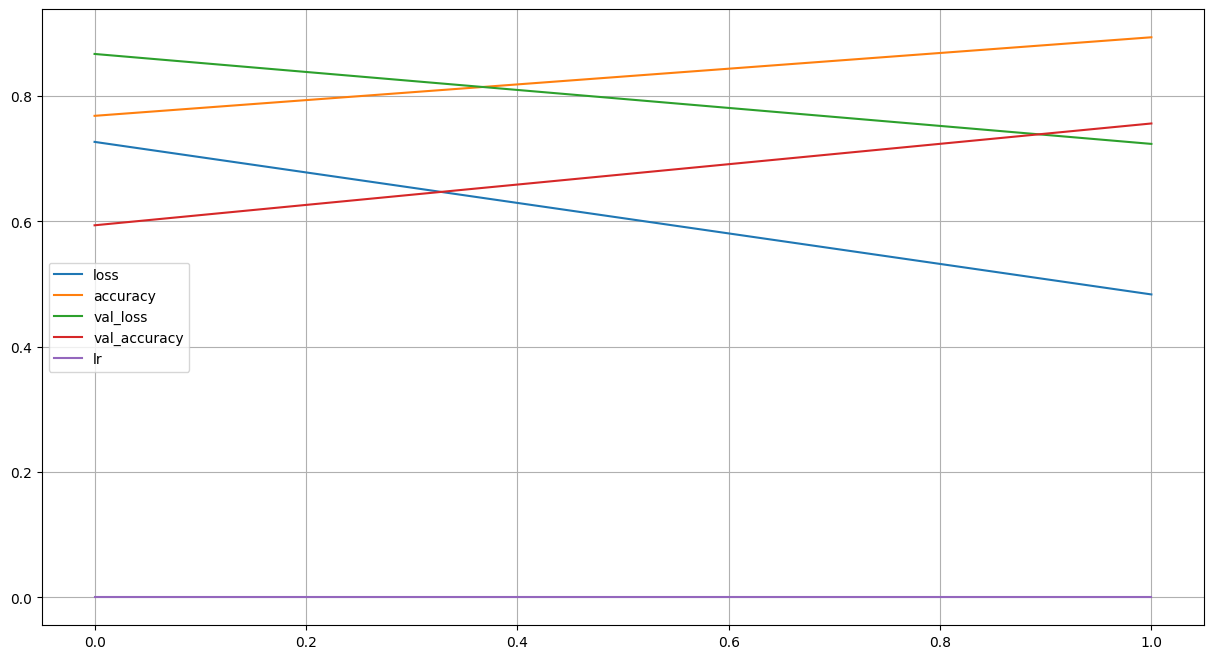

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca()
plt.show()

In [ ]:
class_names = ["COVID", "Normanl", "Viral Pneumonia"]

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confusion Matrix and Classification Report
y_pred=model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

18/18 [==============================] - 2s 94ms/step
Confusion Matrix
[[38 19 33]
 [ 6 74 20]
 [ 0  0 98]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.86      0.42      0.57        90
        Normanl       0.80      0.74      0.77       100
Viral Pneumonia       0.65      1.00      0.79        98

       accuracy                           0.73       288
      macro avg       0.77      0.72      0.71       288
   weighted avg       0.77      0.73      0.71       288



<Figure size 800x800 with 0 Axes>

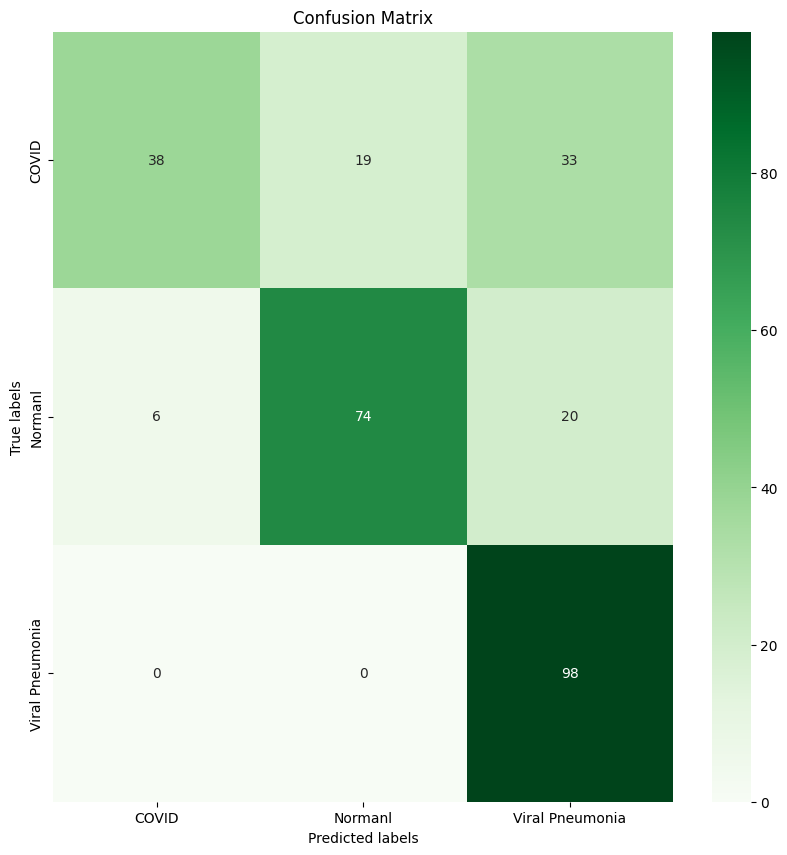

In [ ]:
import seaborn as sb

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(cnf_matrix, annot=True, fmt='g', cmap='Greens')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names)
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(10, 10)


plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("\nAccuracy: {:.4f}".format(accuracy))


Accuracy: 0.7292


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test holds the true labels and y_classes holds the predicted labels
# Calculate classification report
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Now, you can access the average values
macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']

weighted_precision = report_dict['weighted avg']['precision']
weighted_recall = report_dict['weighted avg']['recall']
weighted_f1 = report_dict['weighted avg']['f1-score']


# Print out the averages
print(f"Macro Average Precision: {macro_precision:.4f}")
print(f"Macro Average Recall: {macro_recall:.4f}")
print(f"Macro Average F1-score: {macro_f1:.4f}\n")

print(f"Weighted Average Precision: {weighted_precision:.4f}")
print(f"Weighted Average Recall: {weighted_recall:.4f}")
print(f"Weighted Average F1-score: {weighted_f1:.4f}\n")

Macro Average Precision: 0.7694
Macro Average Recall: 0.7207
Macro Average F1-score: 0.7071

Weighted Average Precision: 0.7670
Weighted Average Recall: 0.7292
Weighted Average F1-score: 0.7114

